# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [3]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-02-26 00:14:18--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  20.2MB/s    in 3.9s    

2025-02-26 00:14:22 (16.7 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
! unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [5]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.

In [6]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

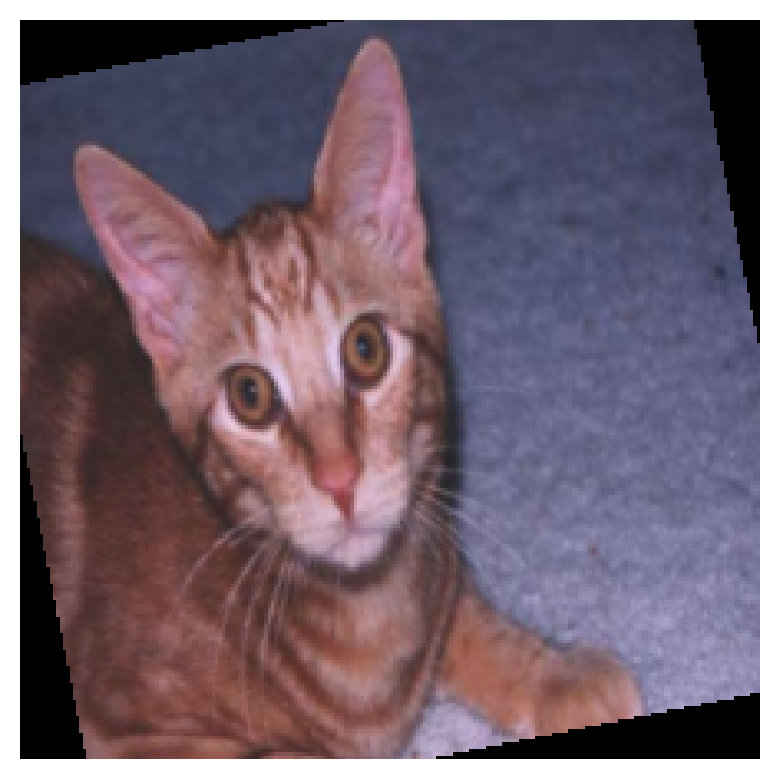

In [19]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[10][0])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [7]:
torch.manual_seed(48)

In [12]:
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)

        # Residual connection: project conv1 output to 128 channels
        self.res_conv = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)

        # Pooling layers
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer for binary classification
        self.fc = nn.Linear(128, 1)

        # Non-linearity
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # First block: Conv -> BN -> ReLU -> Pool
        x1 = self.pool(self.relu(self.bn1(self.conv1(x))))  # shape: (B,64,H/2,W/2)

        # Residual branch: project x1 to 128 channels
        residual = self.res_conv(x1)  # shape: (B,128,H/2,W/2)

        # Second block: Conv -> BN -> ReLU
        x2 = self.relu(self.bn2(self.conv2(x1)))  # shape: (B,128,H/2,W/2)

        # Add the residual connection
        x2 = x2 + residual

        # Further pooling to reduce spatial dimensions
        x2 = self.pool(x2)  # shape: (B,128,H/4,W/4)
        x2 = self.adaptive_pool(x2)  # shape: (B,128,1,1)

        # Flatten and apply fully connected layer
        x2 = x2.view(x2.size(0), -1)  # shape: (B,128)
        x2 = self.fc(x2)              # shape: (B,1)

        return x2

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [13]:
from tqdm.notebook import tqdm

def get_loss_and_correct(model, batch, criterion, device):
  # Unpack the batch
  images, labels = batch
  images = images.to(device)
  labels = labels.to(device).float().unsqueeze(1)

  # Forward pass
  outputs = model(images)
  loss = criterion(outputs, labels)

  # Compute predictions and count correct ones
  preds = (torch.sigmoid(outputs) > 0.5).float()
  correct = (preds == labels).sum()

  return loss, correct

def step(loss, optimizer):
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


N_EPOCHS = 12
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)
model = CNN()

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

if torch.cuda.is_available():
  model = model.cuda()
  criterion = criterion.cuda()
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

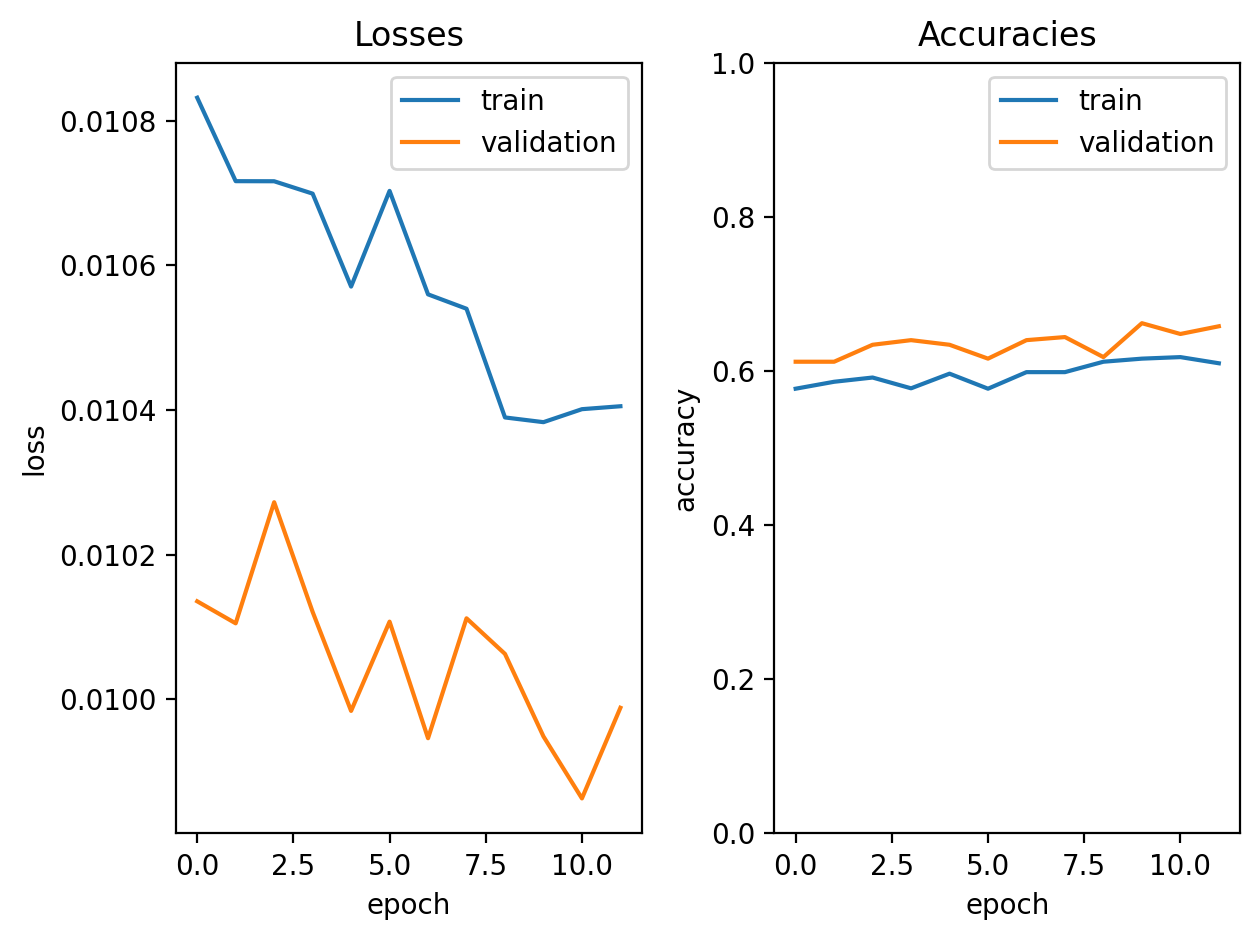

In [14]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

(Please find the implementation of the updated model separately below. Adjusted augmentaions, increased model capacity and tuned the optimizer.)

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
For the following model, the model does seem to overfit as over time, the training accuracy keeps rising (and training loss keeps dropping), but the validation accuracy plateaus or fluctuates at a lower level. Also, the training loss steadily decreases, while the validation loss remains higher and does not consistently improve, which is another sign that model is fitting training data more than it is generalizing.

In [8]:
# Updated normalization for typical ImageNet-scale models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15, interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    normalize,
])

validation_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# Recreate datasets with updated transforms
train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms),
    [500, 500],
    generator=torch.Generator().manual_seed(42)
)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class LargerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1: in 3 -> out 64
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # Block 2: in 64 -> out 128
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # Block 3: in 128 -> out 256
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # Block 4: in 256 -> out 512
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        # Adaptive pooling -> fully connected layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 1)  # For binary classification

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.adaptive_pool(x)           # shape: (B, 512, 1, 1)
        x = x.view(x.size(0), -1)          # shape: (B, 512)
        x = self.fc(x)                     # shape: (B, 1)
        return x

In [11]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm

# Hyperparameters
BATCH_SIZE = 32
N_EPOCHS = 25
LR = 0.0005

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LargerCNN().to(device)

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

def get_loss_and_correct(model, batch, criterion, device):
    images, labels = batch
    images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

    outputs = model(images)
    loss = criterion(outputs, labels)

    # Compute number of correct predictions
    preds = (torch.sigmoid(outputs) > 0.5).float()
    correct = (preds == labels).sum()

    return loss, correct

def step(loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(N_EPOCHS):
    model.train()
    running_train_loss, running_train_correct = 0.0, 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}", leave=False):
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        running_train_loss += loss.item()
        running_train_correct += correct.item()

    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_acc = running_train_correct / len(train_dataset)

    # Validation
    model.eval()
    running_val_loss, running_val_correct = 0.0, 0.0

    with torch.no_grad():
        for batch in validation_loader:
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            running_val_loss += loss.item()
            running_val_correct += correct.item()

    epoch_val_loss = running_val_loss / len(validation_dataset)
    epoch_val_acc = running_val_correct / len(validation_dataset)

    # Step the scheduler based on validation loss
    scheduler.step(epoch_val_loss)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_accuracies.append(epoch_train_acc)
    val_accuracies.append(epoch_val_acc)
    print(f"[Epoch {epoch+1}/{N_EPOCHS}] Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.3f}")

Epoch 1/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 1/25] Train Loss: 0.0214, Train Acc: 0.587 | Val Loss: 0.0224, Val Acc: 0.568


Epoch 2/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 2/25] Train Loss: 0.0204, Train Acc: 0.610 | Val Loss: 0.0195, Val Acc: 0.648


Epoch 3/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 3/25] Train Loss: 0.0198, Train Acc: 0.645 | Val Loss: 0.0185, Val Acc: 0.714


Epoch 4/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 4/25] Train Loss: 0.0199, Train Acc: 0.639 | Val Loss: 0.0209, Val Acc: 0.582


Epoch 5/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 5/25] Train Loss: 0.0194, Train Acc: 0.651 | Val Loss: 0.0186, Val Acc: 0.694


Epoch 6/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 6/25] Train Loss: 0.0192, Train Acc: 0.672 | Val Loss: 0.0188, Val Acc: 0.674


Epoch 7/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 7/25] Train Loss: 0.0186, Train Acc: 0.683 | Val Loss: 0.0219, Val Acc: 0.630


Epoch 8/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 8/25] Train Loss: 0.0180, Train Acc: 0.707 | Val Loss: 0.0239, Val Acc: 0.560


Epoch 9/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 9/25] Train Loss: 0.0176, Train Acc: 0.721 | Val Loss: 0.0187, Val Acc: 0.718


Epoch 10/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 10/25] Train Loss: 0.0172, Train Acc: 0.731 | Val Loss: 0.0184, Val Acc: 0.700


Epoch 11/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 11/25] Train Loss: 0.0169, Train Acc: 0.731 | Val Loss: 0.0182, Val Acc: 0.696


Epoch 12/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 12/25] Train Loss: 0.0167, Train Acc: 0.726 | Val Loss: 0.0183, Val Acc: 0.688


Epoch 13/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 13/25] Train Loss: 0.0170, Train Acc: 0.736 | Val Loss: 0.0175, Val Acc: 0.730


Epoch 14/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 14/25] Train Loss: 0.0166, Train Acc: 0.729 | Val Loss: 0.0198, Val Acc: 0.702


Epoch 15/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 15/25] Train Loss: 0.0165, Train Acc: 0.741 | Val Loss: 0.0170, Val Acc: 0.734


Epoch 16/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 16/25] Train Loss: 0.0161, Train Acc: 0.750 | Val Loss: 0.0175, Val Acc: 0.736


Epoch 17/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 17/25] Train Loss: 0.0162, Train Acc: 0.745 | Val Loss: 0.0170, Val Acc: 0.748


Epoch 18/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 18/25] Train Loss: 0.0161, Train Acc: 0.746 | Val Loss: 0.0168, Val Acc: 0.734


Epoch 19/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 19/25] Train Loss: 0.0157, Train Acc: 0.753 | Val Loss: 0.0189, Val Acc: 0.718


Epoch 20/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 20/25] Train Loss: 0.0159, Train Acc: 0.763 | Val Loss: 0.0169, Val Acc: 0.760


Epoch 21/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 21/25] Train Loss: 0.0157, Train Acc: 0.759 | Val Loss: 0.0201, Val Acc: 0.712


Epoch 22/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 22/25] Train Loss: 0.0159, Train Acc: 0.759 | Val Loss: 0.0194, Val Acc: 0.700


Epoch 23/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 23/25] Train Loss: 0.0153, Train Acc: 0.766 | Val Loss: 0.0179, Val Acc: 0.724


Epoch 24/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 24/25] Train Loss: 0.0147, Train Acc: 0.783 | Val Loss: 0.0169, Val Acc: 0.750


Epoch 25/25:   0%|          | 0/63 [00:00<?, ?it/s]

[Epoch 25/25] Train Loss: 0.0150, Train Acc: 0.780 | Val Loss: 0.0179, Val Acc: 0.722


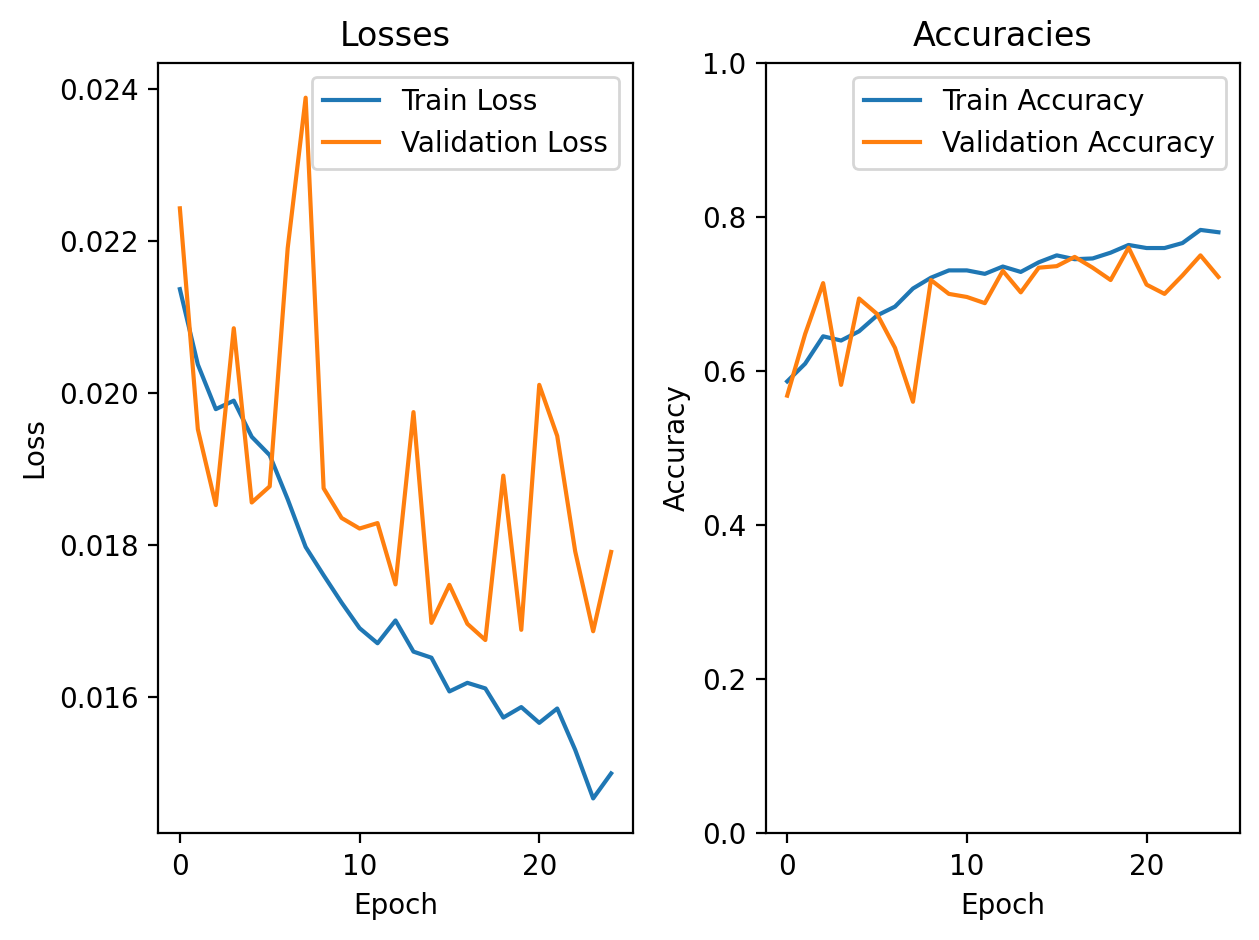

In [12]:
import matplotlib.pyplot as plt

plt.figure(dpi=200)

# Plot the losses
plt.subplot(121)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

# Plot the accuracies
plt.subplot(122)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
print(f"[Epoch {epoch+1}/{N_EPOCHS}] "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.3f} "
          f"| Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.3f}")

[Epoch 25/25] Train Loss: 0.0150, Train Acc: 0.772 | Val Loss: 0.0170, Val Acc: 0.738


### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [13]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 71.20%


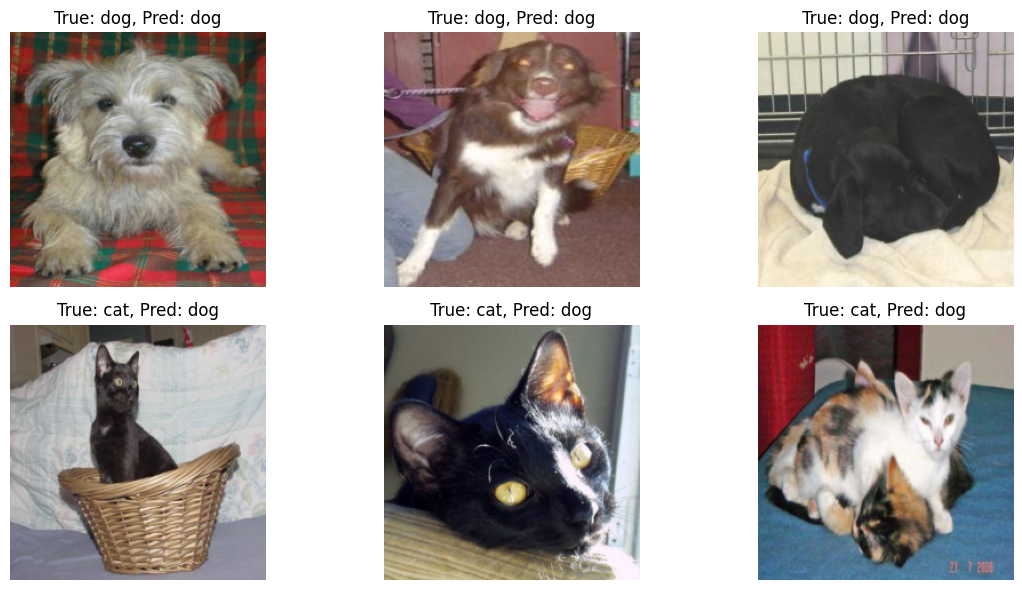

In [17]:
import random

# Unnormalize transform (matching our training normalization)
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_image(img, true_label, pred_label=None):
    """Displays a single image, unnormalized, with optional title."""
    # Unnormalize
    img_unnormalized = unnormalize(img)
    img_unnormalized = torch.clamp(img_unnormalized, 0, 1)

    np_img = img_unnormalized.permute(1, 2, 0).cpu().numpy()
    plt.imshow(np_img)
    if pred_label is not None:
        plt.title(f"True: {true_label}, Pred: {pred_label}")
    else:
        plt.title(f"Label: {true_label}")
    plt.axis('off')

# Collect correct and incorrect predictions
correct_examples = []
incorrect_examples = []

model.eval()
with torch.no_grad():
    for i in range(len(test_dataset)):
        img, label = test_dataset[i]

        input_img = img.unsqueeze(0).to(device)
        output = model(input_img)
        pred = (torch.sigmoid(output) > 0.5).float().item()

        if pred == label:
            correct_examples.append((img, label, pred))
        else:
            incorrect_examples.append((img, label, pred))

# Plot some correct examples
plt.figure(figsize=(12, 6))
for idx in range(3):
    plt.subplot(2, 3, idx+1)
    img, true_label, pred_label = random.choice(correct_examples)
    show_image(img, 'dog' if true_label == 1 else 'cat', 'dog' if pred_label == 1.0 else 'cat')

# Plot some incorrect examples
for idx in range(3):
    plt.subplot(2, 3, idx+4)
    img, true_label, pred_label = random.choice(incorrect_examples)
    show_image(img, 'dog' if true_label == 1 else 'cat', 'dog' if pred_label == 1.0 else 'cat')

plt.tight_layout()
plt.show()

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

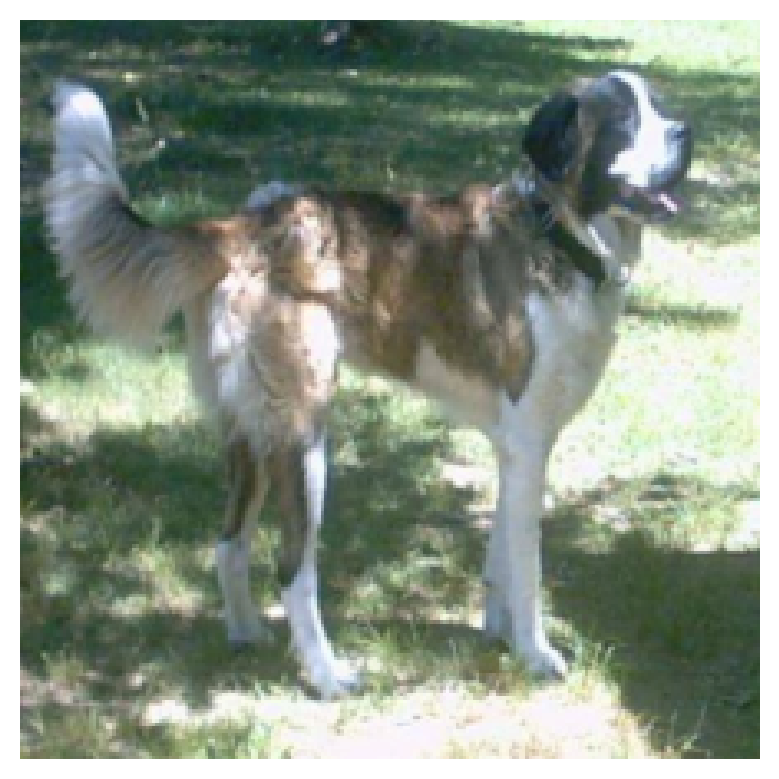

In [20]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



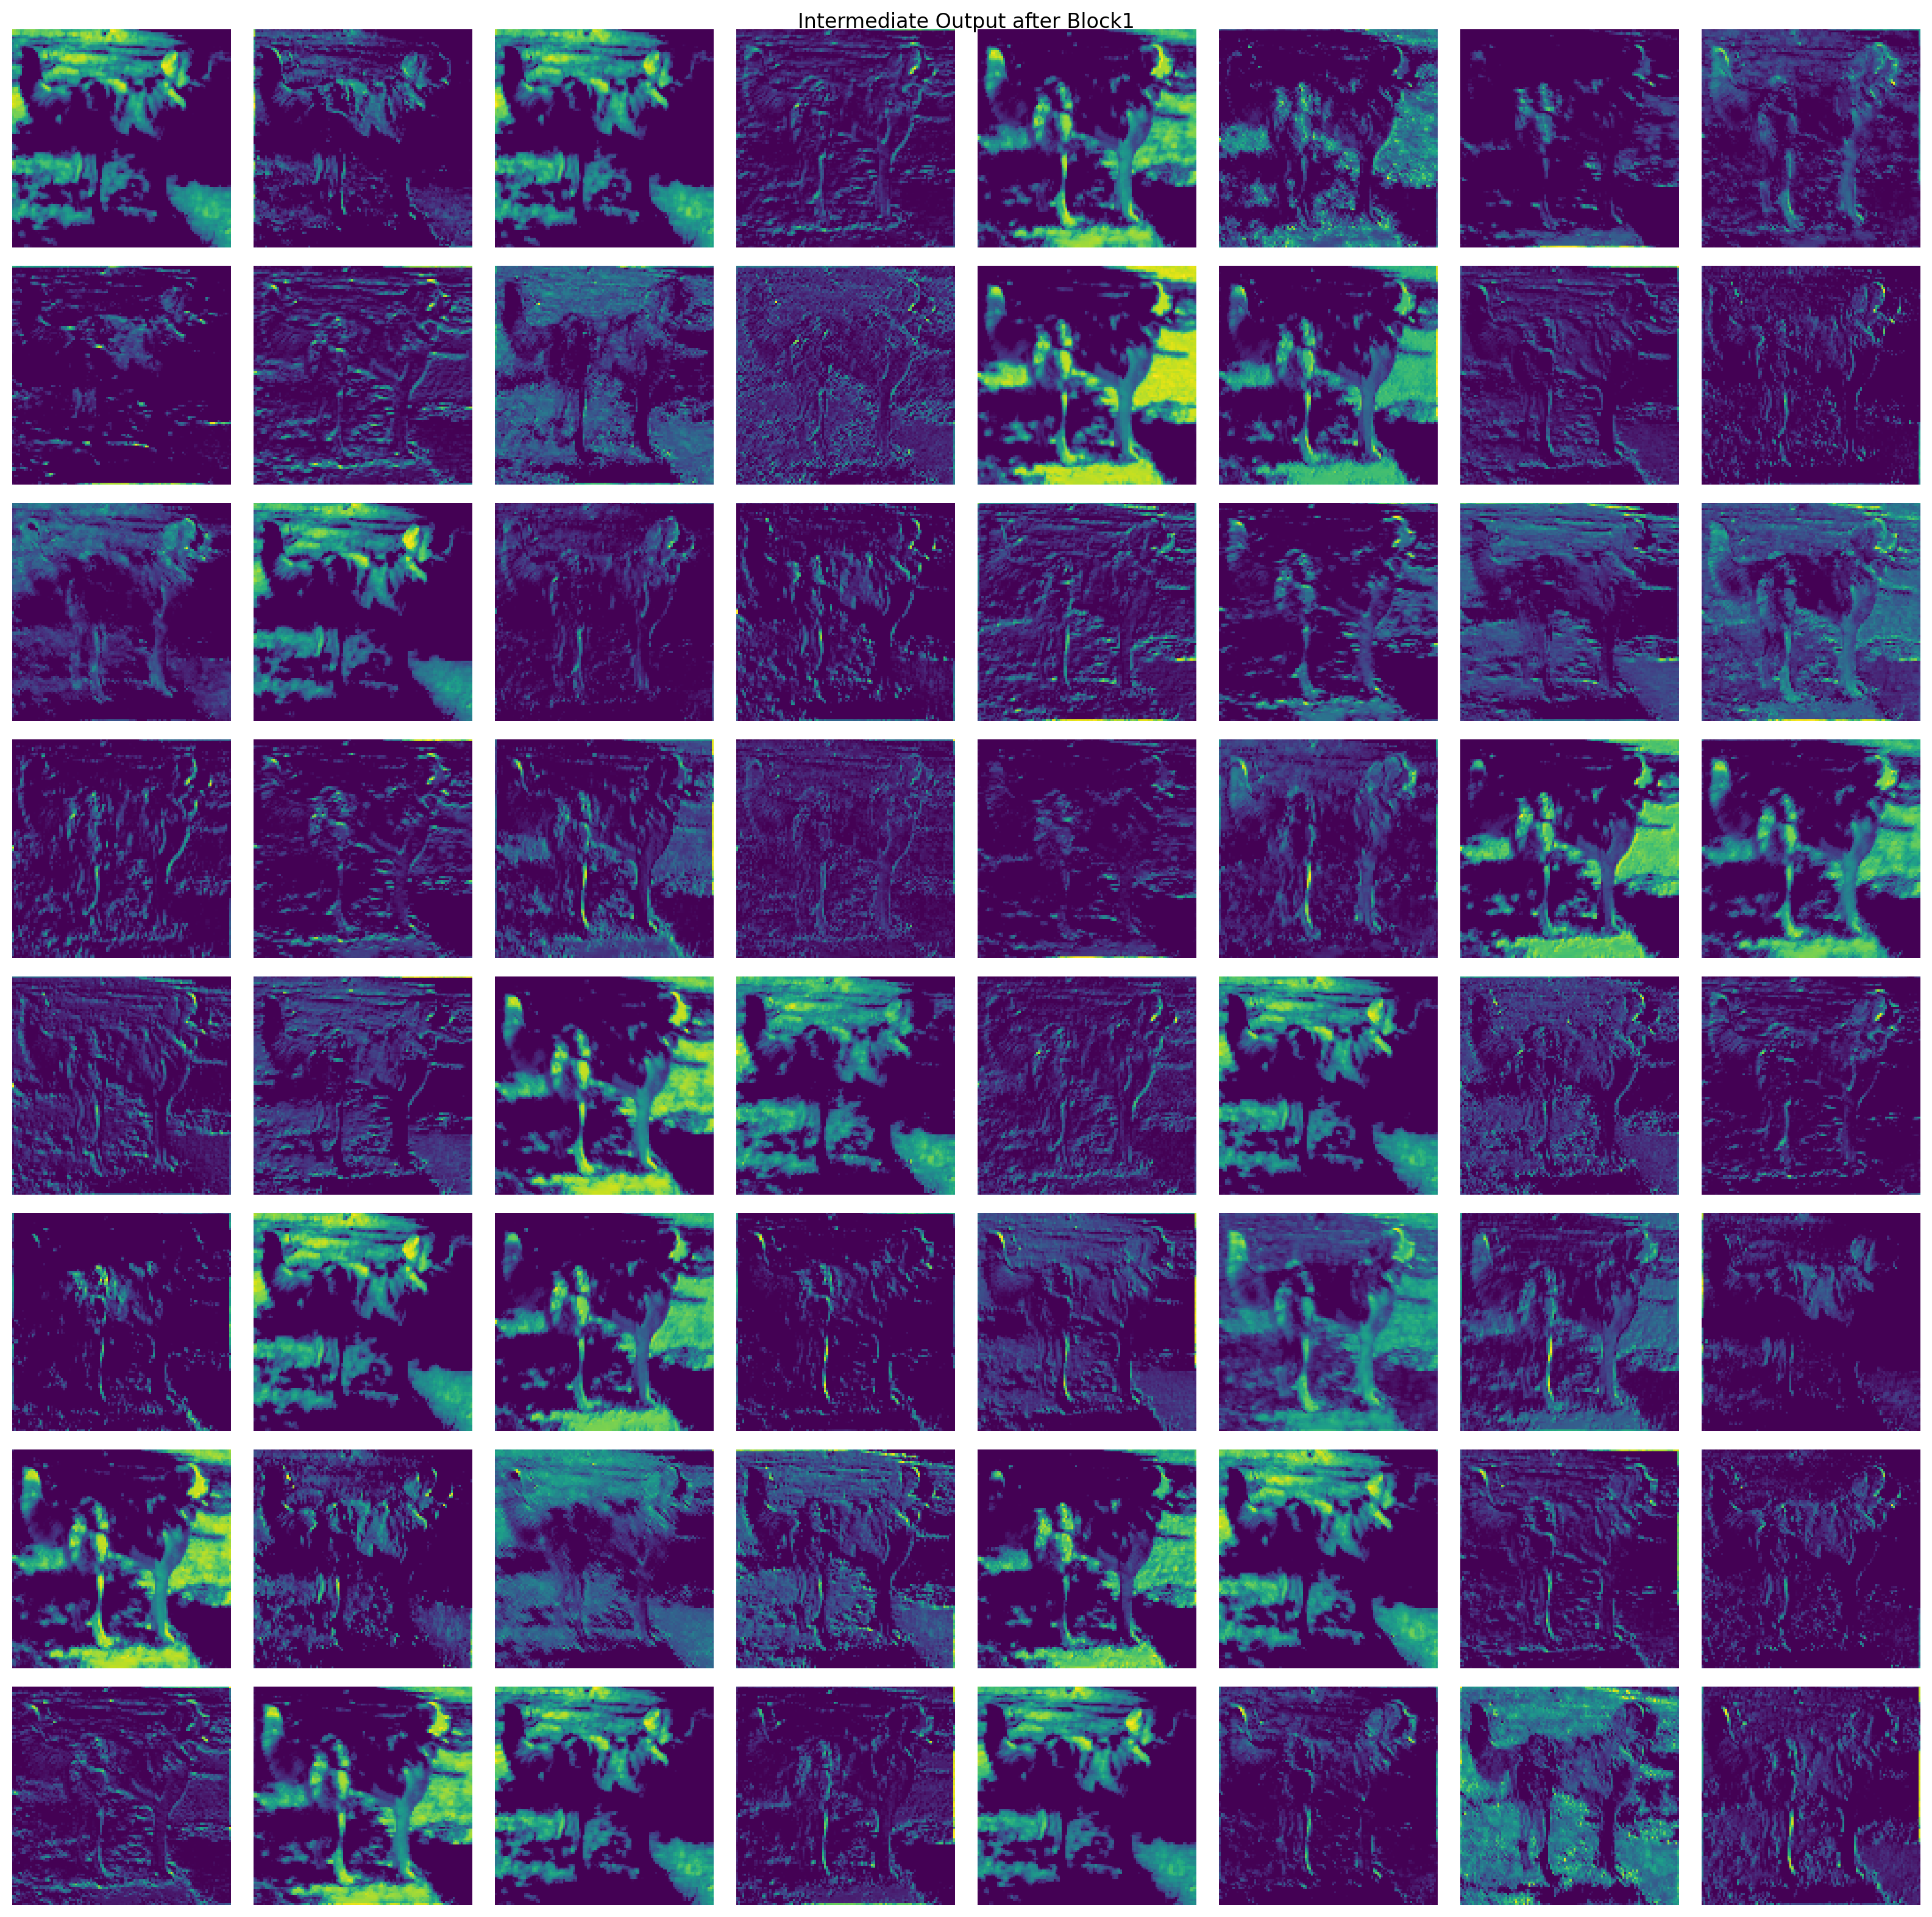

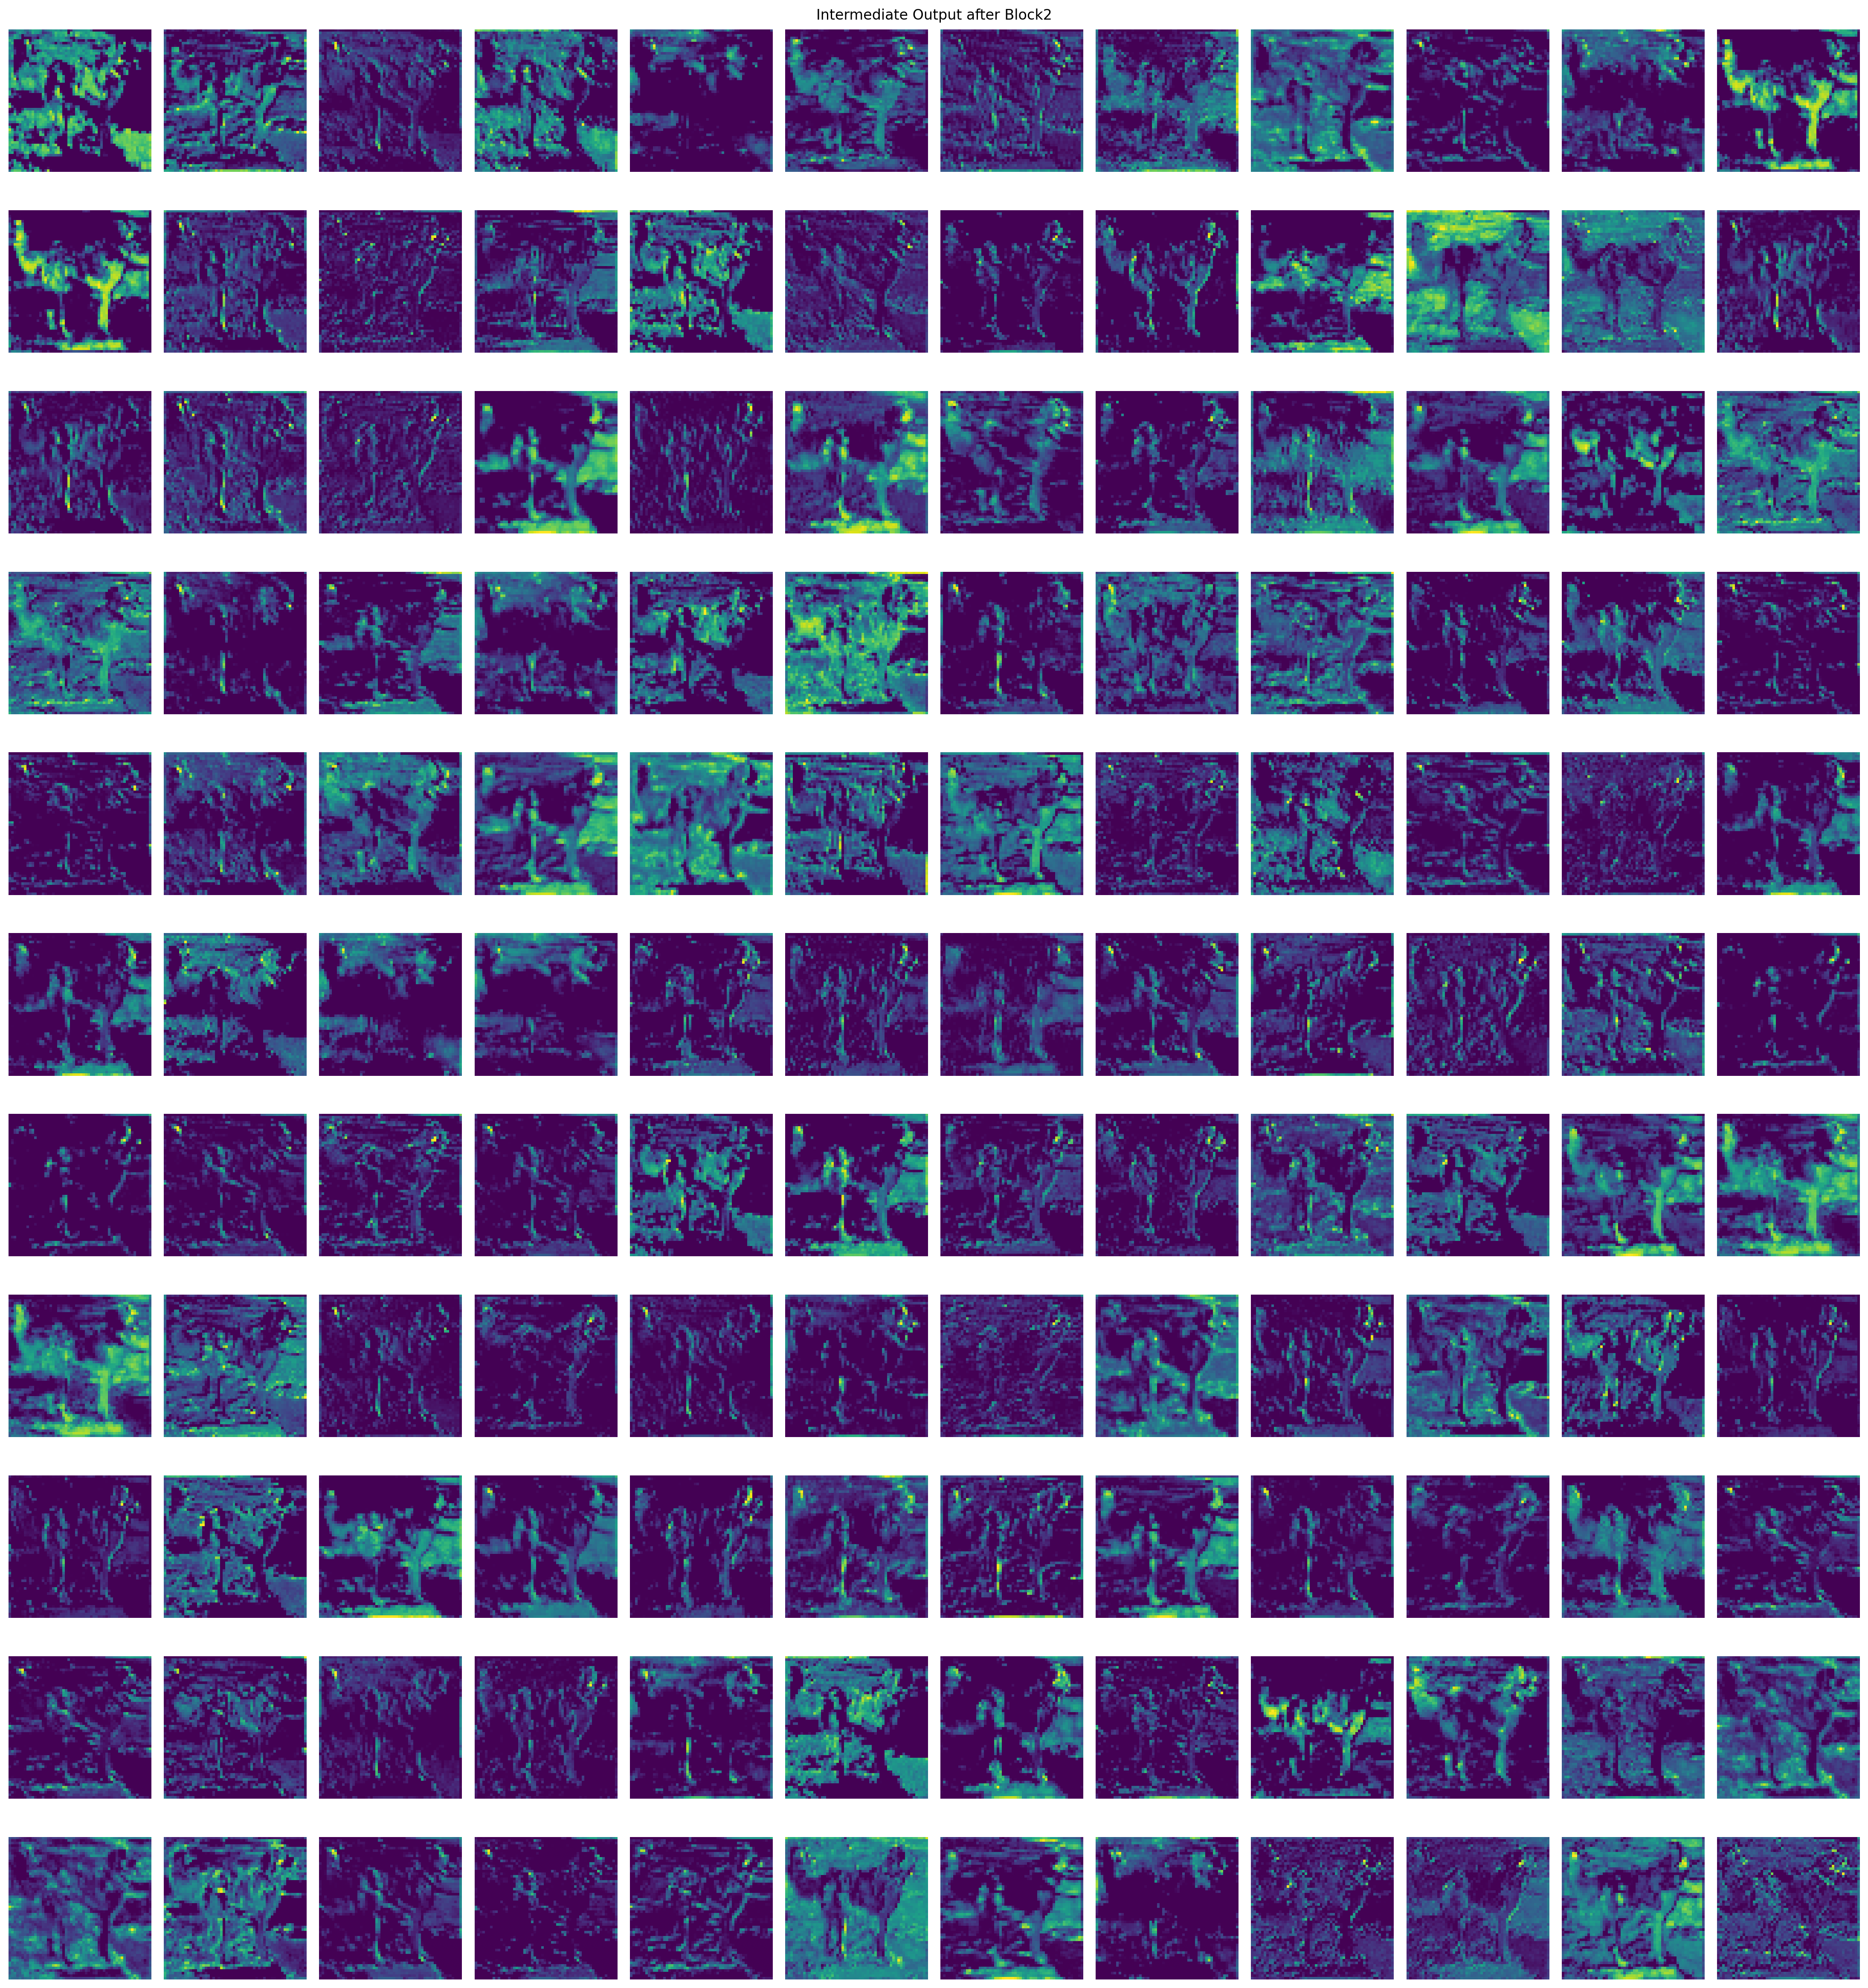

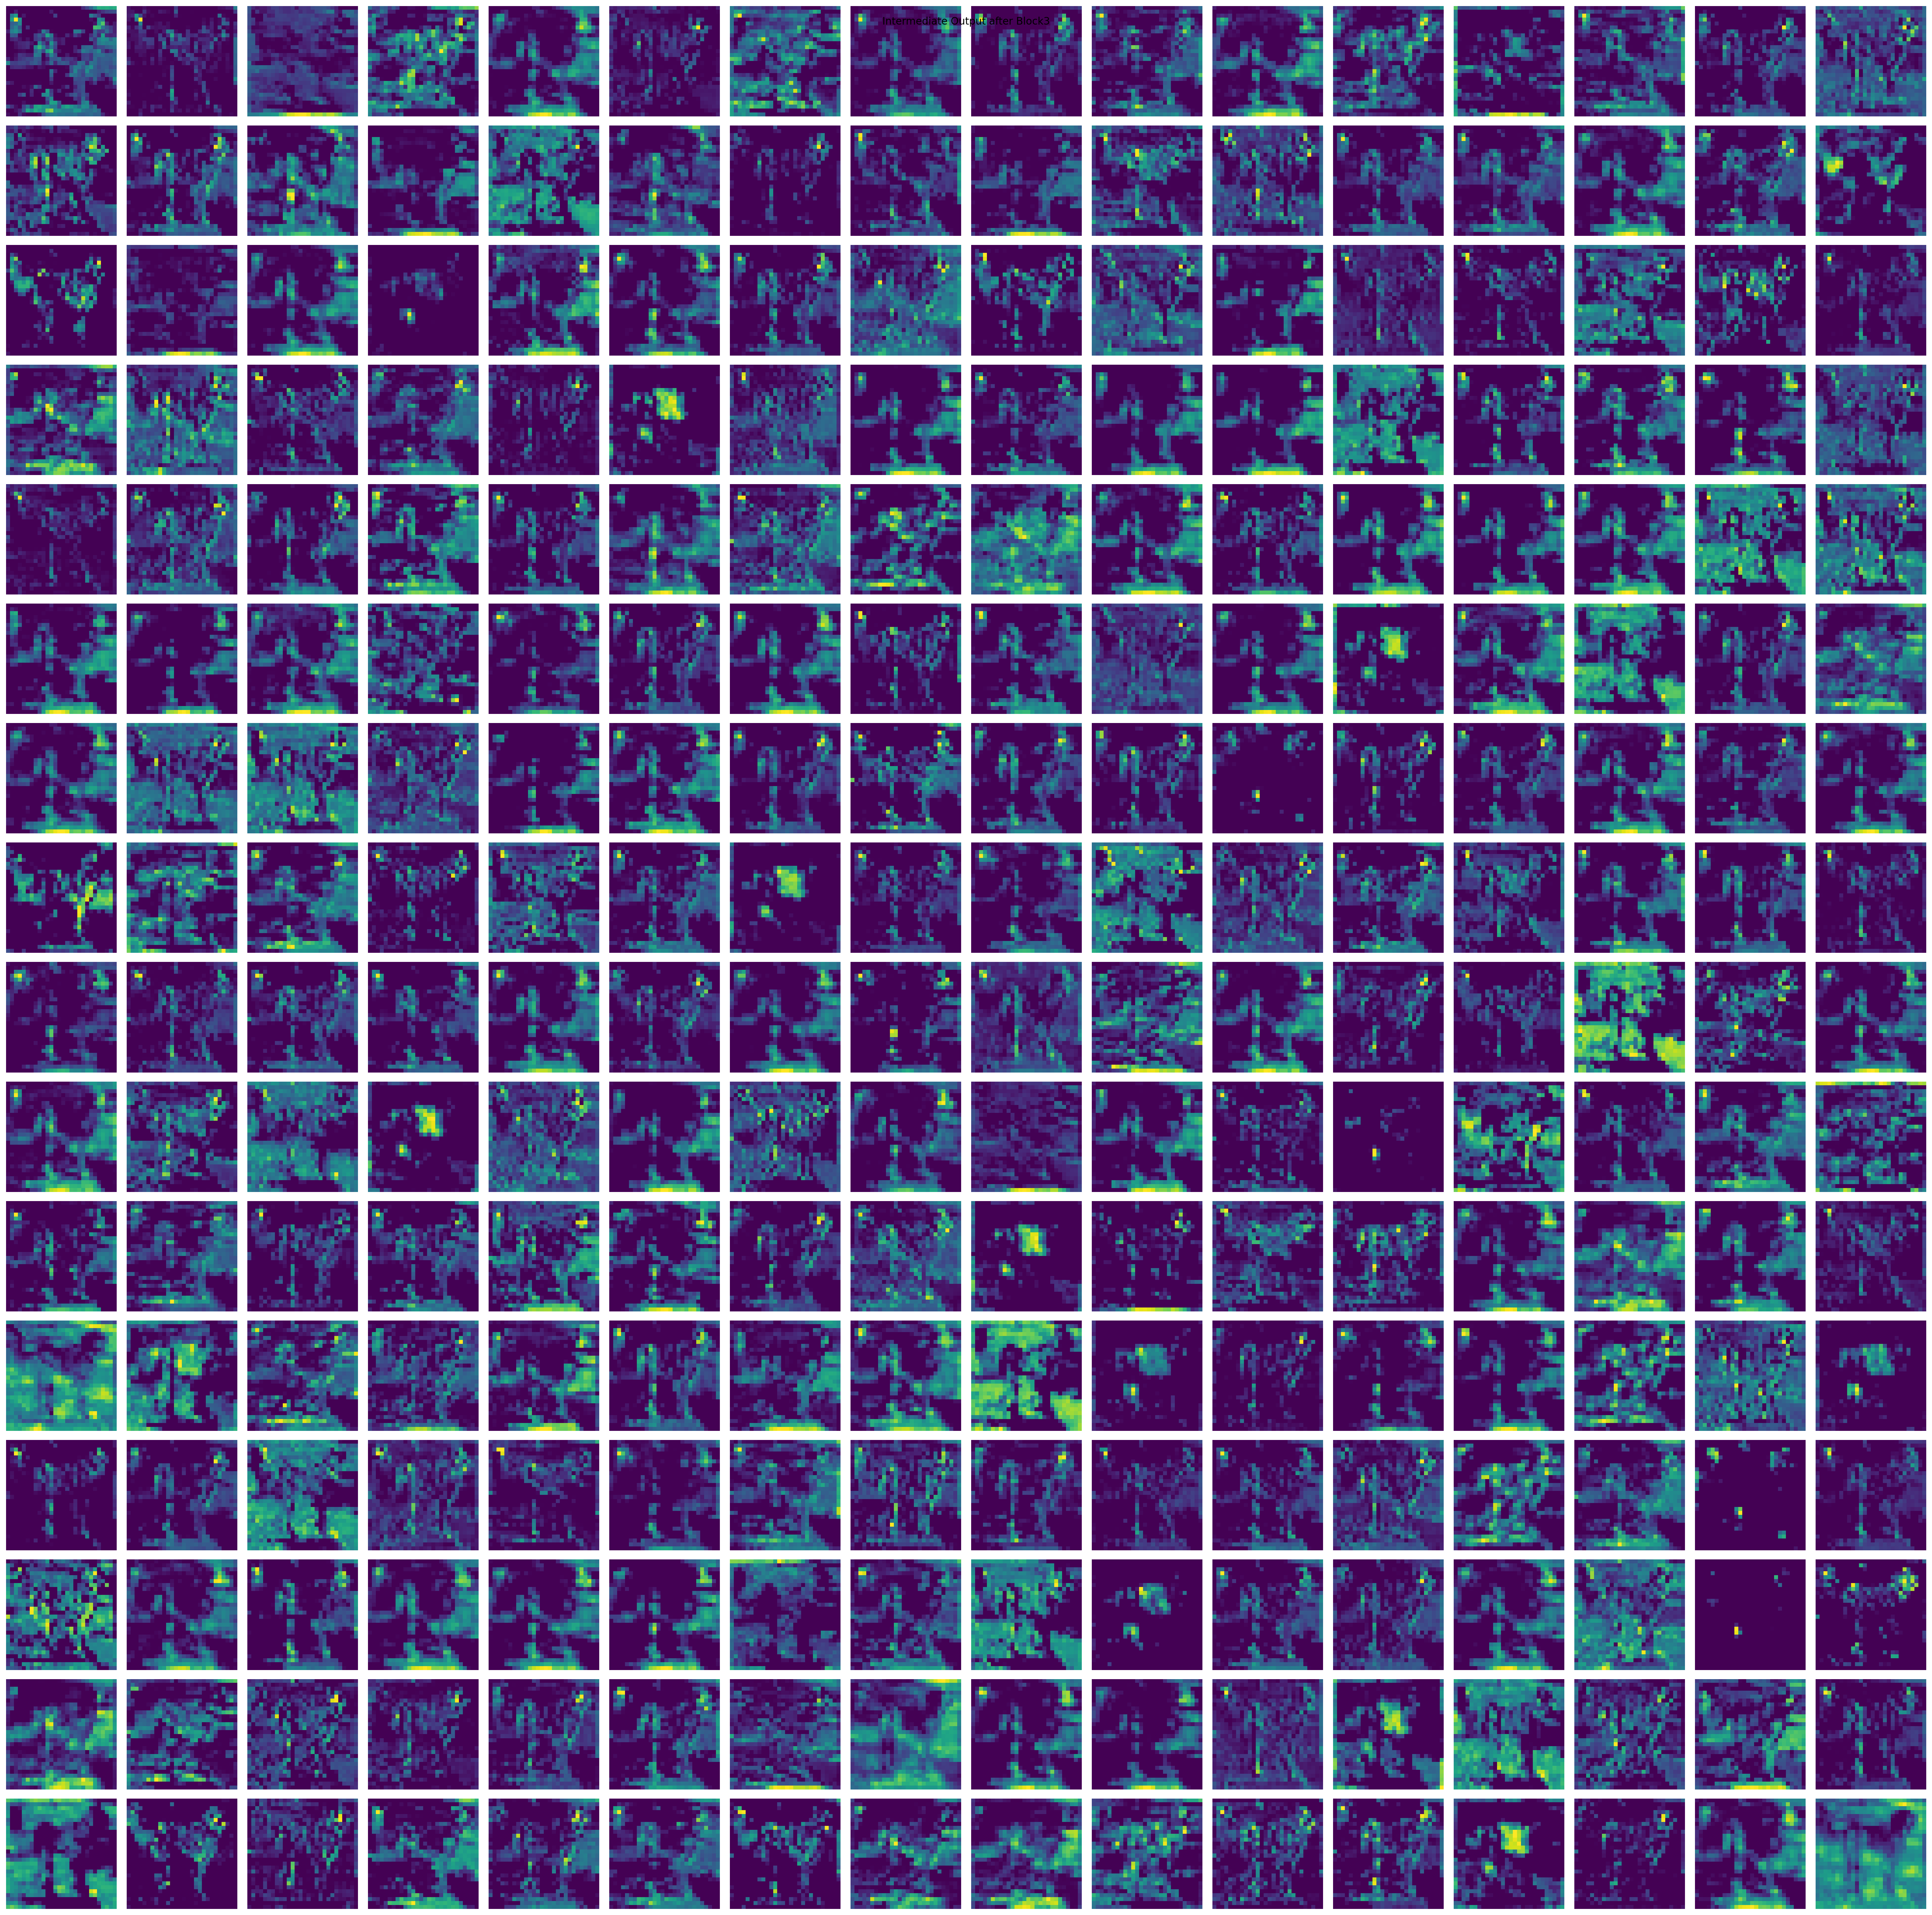

In [22]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters

  fig, axs = plt.subplots(N, M, figsize=(2*N, 2*M))
  fig.suptitle(title)

  for i in range(N):
    for j in range(M):
      idx = i * N + j
      if idx < n_filters:
        axs[i][j].imshow(result[0, idx].cpu().detach(), cmap='viridis')
        axs[i][j].axis('off')
  plt.tight_layout()
  plt.show()

model.eval()
device = next(model.parameters()).device
input_tensor = image.unsqueeze(0).to(device)

# Clip the model at various blocks
# Plot the output after block1
output_block1 = model.block1(input_tensor)
plot_intermediate_output(output_block1, "Intermediate Output after Block1")

# Output after block2
output_block2 = model.block2(output_block1)
plot_intermediate_output(output_block2, "Intermediate Output after Block2")

# Output after block3
output_block3 = model.block3(output_block2)
plot_intermediate_output(output_block3, "Intermediate Output after Block3")

# Output after block4
output_block4 = model.block4(output_block3)
plot_intermediate_output(output_block4, "Intermediate Output after Block4")

What can you say about those filters? What features are they focusing on?

Anwer: We can see that early layers focus on low-level details like edges, corners (to do with the general shape). Deeper layers (although difficult to see clearly) capture more abstract features (like fur, face structure). Bright spots indicate strong activations and show important regions for classification.